WT_Phospho.txt is obtained from Phosphoproteomic Data G579S_Veh vs G579S_OTSFor the GO-terms obtained per cluster, the genes were put into Enrichr that produced standard list of GO terms

In [ ]:
import pandas as pd
import requests
from io import StringIO
import time
import matplotlib.pyplot as plt
import seaborn as sns
# Step 1: Load your phosphoprotein list
gene_list_file = '/Users/sanatmishra27/Downloads/WT_Phospho.txt'
gene_df = pd.read_csv(gene_list_file, header=None)
gene_list = gene_df.iloc[:, 0].dropna().unique().tolist()
print(f"Total genes to query: {len(gene_list)}")
print(f"First 10 genes: {gene_list[:10]}")
def query_string_with_debug(gene_list, species=9606, required_score=400):
    """Query STRING API with debugging information"""
    identifiers = "\n".join(gene_list)
    url = "https://string-db.org/api/tsv/network"
    data = {
        'identifiers': identifiers,
        'species': species,
        'required_score': required_score
    }
    print(f"\nQuerying STRING with confidence threshold: {required_score}")
    response = requests.post(url, data=data)
    if response.status_code != 200:
        print(f"API request failed with status code {response.status_code}")
        print(f"Response text: {response.text}")
        return None
    # Check if response is empty
    if not response.text.strip():
        print("Empty response from STRING API")
        return None
    try:
        ppi_df = pd.read_csv(StringIO(response.text), sep="\t")
        print(f"Raw interactions retrieved: {len(ppi_df)}")
        if len(ppi_df) > 0:
            print(f"Score range: {ppi_df['score'].min()} - {ppi_df['score'].max()}")
            print(f"Columns available: {list(ppi_df.columns)}")
            # Show score distribution
            print("\nScore distribution:")
            print(ppi_df['score'].describe())
        return ppi_df
    except Exception as e:
        print(f"Error parsing response: {e}")
        print(f"Response text (first 500 chars): {response.text[:500]}")
        return None
# Test with different confidence thresholds
confidence_levels = [150, 200, 400, 500, 700, 900]
results = {}
for conf in confidence_levels:
    print(f"\n{'='*50}")
    print(f"Testing confidence level: {conf}")
    ppi_df = query_string_with_debug(gene_list, required_score=conf)
    if ppi_df is not None and len(ppi_df) > 0:
        # Filter for interactions within your gene list
        ppi_edges = list(zip(ppi_df['preferredName_A'], ppi_df['preferredName_B']))
        ppi_edges_filtered = [(a, b) for a, b in ppi_edges if a in gene_list and b in gene_list]
        results[conf] = {
            'total_interactions': len(ppi_df),
            'within_genelist': len(ppi_edges_filtered),
            'dataframe': ppi_df
        }
        print(f"Total interactions: {len(ppi_df)}")
        print(f"Interactions within your gene list: {len(ppi_edges_filtered)}")
        # Show some example interactions
        if len(ppi_edges_filtered) > 0:
            print(f"Example interactions: {ppi_edges_filtered[:5]}")
    else:
        results[conf] = {'total_interactions': 0, 'within_genelist': 0, 'dataframe': None}
        print("No interactions found")
    time.sleep(1)  # Be respectful to the API
print(f"\n{'='*50}")
print("SUMMARY OF RESULTS:")
print(f"{'Confidence':<12} {'Total':<10} {'Within List':<12}")
print("-" * 35)
for conf, result in results.items():
    print(f"{conf:<12} {result['total_interactions']:<10} {result['within_genelist']:<12}")
# Find the best confidence level
best_conf = None
best_count = 0
for conf, result in results.items():
    if result['within_genelist'] > best_count:
        best_count = result['within_genelist']
        best_conf = conf
if best_conf:
    print(f"\nRecommended confidence level: {best_conf} ({best_count} interactions)")
    # Use the best confidence level for final analysis
    final_ppi_df = results[best_conf]['dataframe']
    if final_ppi_df is not None and len(final_ppi_df) > 0:
        # Create final filtered edges
        ppi_edges = list(zip(final_ppi_df['preferredName_A'], final_ppi_df['preferredName_B']))
        ppi_edges_filtered = [(a, b) for a, b in ppi_edges if a in gene_list and b in gene_list]
        # Save results
        ppi_output = pd.DataFrame(ppi_edges_filtered, columns=['Protein_A', 'Protein_B'])
        # Add scores to the output
        edge_scores = {}
        for _, row in final_ppi_df.iterrows():
            key = (row['preferredName_A'], row['preferredName_B'])
            edge_scores[key] = row['score']
        ppi_output['Score'] = ppi_output.apply(lambda x: edge_scores.get((x['Protein_A'], x['Protein_B']), 0), axis=1)
        # Sort by score (highest first)
        ppi_output = ppi_output.sort_values('Score', ascending=False)
        ppi_output.to_csv('/Users/sanatmishra27/Downloads/WT_PPI_edges.tsv', sep='\t', index=False)
        print(f"\nFinal results saved to: /Users/sanatmishra27/Downloads/WT_PPI_edges.tsv")
        print(f"Total interactions: {len(ppi_output)}")
        print(f"Score range: {ppi_output['Score'].min()} - {ppi_output['Score'].max()}")
        # Show top interactions
        print("\nTop 10 interactions by score:")
        print(ppi_output.head(10).to_string(index=False))
        # Plot score distribution
        plt.figure(figsize=(10, 6))
        plt.hist(ppi_output['Score'], bins=20, alpha=0.7, edgecolor='black')
        plt.xlabel('STRING Confidence Score')
        plt.ylabel('Number of Interactions')
        plt.title(f'Distribution of STRING Confidence Scores (n={len(ppi_output)})')
        plt.grid(True, alpha=0.3)
        plt.savefig('/Users/sanatmishra27/Downloads/STRING_score_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
else:
    print("\nNo interactions found at any confidence level!")
    print("This could indicate:")
    print("1. Gene names might not be recognized by STRING")
    print("2. Your genes might not have known interactions")
    print("3. There might be an issue with the gene list format")
    # Debug: Check a few genes individually
    print("\nTesting individual genes:")
    test_genes = gene_list[:5]  # Test first 5 genes
    for gene in test_genes:
        url = "https://string-db.org/api/tsv/network"
        data = {
            'identifiers': gene,
            'species': 9606,
            'required_score': 150
        }
        response = requests.post(url, data=data)
        if response.status_code == 200 and response.text.strip():
            test_df = pd.read_csv(StringIO(response.text), sep="\t")
            print(f"  {gene}: {len(test_df)} interactions found")
        else:
            print(f"  {gene}: No interactions or not recognized")
        time.sleep(0.5)

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import community
from collections import defaultdict
from matplotlib.colors import to_hex
from matplotlib import cm
from matplotlib.patheffects import withStroke
import random
random.seed(26)
np.random.seed(26)
# === Load phosphoproteomics data ===
file_path = '/Users/sanatmishra27/Downloads/CDK11/Paper/Fig2/Phosphoproteomics/JV256_phos_n3_analysis.xlsx'
sheet_df = pd.read_excel(file_path, sheet_name='Sheet1')
sheet_df['Protein Name'] = sheet_df['Protein Id'].str.split('|').str[2].str.split('_').str[0]
# Define columns
p_col = 'pvalue(WT)'
log2fc_wt_col = 'log2 fold change (WT_Veh vs. WT_OTS)'
log2fc_g579s_col = 'log2 fold change (G579S_Veh vs G579S_OTS)'
# Drop NA and filter for significance
sheet_df = sheet_df.dropna(subset=[p_col, log2fc_wt_col, log2fc_g579s_col])
sig_df = sheet_df[sheet_df[p_col] < 0.05]
# === Load STRING PPI ===
ppi_df = pd.read_csv('/Users/sanatmishra27/Downloads/WT_PPI_edges.tsv', sep='\t')
valid_proteins = set(sig_df['Protein Name'])
ppi_filtered = ppi_df[
    (ppi_df['Protein_A'].isin(valid_proteins)) &
    (ppi_df['Protein_B'].isin(valid_proteins))
]
# === Build Graph ===
G = nx.Graph()
for _, row in sig_df.iterrows():
    name = row['Protein Name']
    G.add_node(name,
               log2fc_wt=row[log2fc_wt_col],
               log2fc_g579s=row[log2fc_g579s_col],
               pval=row[p_col])
for _, row in ppi_filtered.iterrows():
    G.add_edge(row['Protein_A'], row['Protein_B'], weight=row['Score'])
# === Louvain Clustering ===
# Louvain clustering
partition = community.best_partition(G)
# Reorder clusters to sequential integers (Cluster 1, 2, 3, ...)
unique_clusters = sorted(set(partition.values()))  # or use sorting by cluster size if needed
cluster_id_map = {orig_id: new_id+1 for new_id, orig_id in enumerate(unique_clusters)}  # +1 to start from 1
# Assign renamed cluster IDs
for node, cluster in partition.items():
    G.nodes[node]['cluster'] = cluster_id_map[cluster]
# === Rescue logic based on signed difference ===
cutoff = 1
min_genes = 2
cluster_data = defaultdict(lambda: {'wt': [], 'g579s': [], 'genes': []})
for node in G.nodes():
    c = G.nodes[node]['cluster']
    cluster_data[c]['wt'].append(G.nodes[node]['log2fc_wt'])
    cluster_data[c]['g579s'].append(G.nodes[node]['log2fc_g579s'])
    cluster_data[c]['genes'].append(node)
summary = []
for c, vals in cluster_data.items():
    if len(vals['genes']) < min_genes:
        continue
    wt_mean = np.mean(vals['wt'])
    g579s_mean = np.mean(vals['g579s'])
    diff = abs(wt_mean - g579s_mean)  # SIGNED difference
    status = 'rescued' if diff < cutoff else 'altered'
    summary.append({
        'cluster': c,
        'mean_log2fc_wt': wt_mean,
        'mean_log2fc_g579s': g579s_mean,
        'abs_diff': diff,
        'status': status,
        'num_genes': len(vals['genes']),
        'genes': vals['genes']
    })
cluster_df = pd.DataFrame(summary)
cluster_df['abs_fc_wt'] = cluster_df['mean_log2fc_wt'].abs()
cluster_df.to_csv('/Users/sanatmishra27/Downloads/phospho_cluster_summary.csv', index=False)
# === Top clusters ===
top_n = 9
top_rescued = cluster_df[cluster_df['status'] == 'rescued'].nlargest(top_n, 'abs_fc_wt')
top_altered = cluster_df[cluster_df['status'] == 'altered'].nlargest(top_n, 'abs_fc_wt')
selected_clusters = pd.concat([top_rescued, top_altered])
selected_genes = set(sum(selected_clusters['genes'].tolist(), []))
# === Build subgraph ===
# === Build subgraph with only rescued proteins ===
H_full = G.subgraph(selected_genes).copy()
# Build cluster-to-status mapping
cluster_status_map = {row['cluster']: row['status'] for row in summary}
for n in H_full.nodes():
    c = G.nodes[n]['cluster']
    H_full.nodes[n]['status'] = cluster_status_map.get(c, 'unknown')
# Filter to keep only nodes with status 'rescued'
rescued_nodes = [n for n, d in H_full.nodes(data=True) if d['status'] == 'rescued']
H = H_full.subgraph(rescued_nodes).copy()
# === Prepare cluster colors ===
clusters_in_subgraph = sorted(set(nx.get_node_attributes(H, 'cluster').values()))
cmap = cm.get_cmap('tab20', len(clusters_in_subgraph))
cluster_colors = {cluster: to_hex(cmap(i)) for i, cluster in enumerate(clusters_in_subgraph)}
# Function to set node border color based on rescue status
def status_edge_color(status):
    if status.lower() == 'rescued':
        return 'green'
    elif status.lower() == 'altered':
        return 'red'
    else:
        return 'gray'
# === Plot ===
import matplotlib as mpl
# Set global font to Arial and increase sizes
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 20  # base size
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
plt.figure(figsize=(18, 16))
pos = nx.spring_layout(H, k=0.5, iterations=100, seed=42)
node_colors = [cluster_colors[H.nodes[n]['cluster']] for n in H.nodes()]
node_edgecolors = [status_edge_color(H.nodes[n]['status']) for n in H.nodes()]
node_sizes = [np.clip(abs(H.nodes[n]['log2fc_wt']), 0.1, 2.5) * 1000 for n in H.nodes()]
# Draw edges
nx.draw_networkx_edges(H, pos, alpha=0.2, width=1.0)
# Draw nodes with cluster fill and rescue status edge colors
nx.draw_networkx_nodes(
    H, pos,
    node_color=node_colors,
    node_size=node_sizes,
    edgecolors=node_edgecolors,
    linewidths=2  # thicker border for visibility
)
# Draw gene labels
nx.draw_networkx_labels(H, pos, font_size=16, font_color='black', font_family='Arial')
# Annotate clusters with cluster ID + rescue status
cluster_centroids = {}
for node, data in H.nodes(data=True):
    cluster = data['cluster']
    if cluster not in cluster_centroids:
        cluster_centroids[cluster] = []
    cluster_centroids[cluster].append(pos[node])
# Legends for clusters and rescue status
# Sort cluster colors by cluster ID
sorted_clusters = sorted(cluster_colors.keys())
# Create Cluster 1, Cluster 2, ... labels in legend
cluster_legend = [
    mpatches.Patch(color=cluster_colors[c], label=f"Cluster {i+1}")
    for i, c in enumerate(sorted_clusters)
]
status_legend = [
    mpatches.Patch(facecolor='white', edgecolor='green', linewidth=2, label='Rescued clusters')
]
plt.legend(handles=cluster_legend + status_legend, loc='upper left', fontsize=10, title="Clusters & Rescue Status")
plt.title("Phospho Clusters: Node Color by Cluster & Border by Rescue Status", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.savefig('/Users/sanatmishra27/Downloads/phospho_annotated_clusters_network.svg', dpi=350)
print(":white_check_mark: Saved:")
print(" - Annotated cluster plot → phospho_annotated_clusters_network.svg")

/var/folders/c3/jvs3mt_j2fg7x12z6gsshy600000gp/T/ipykernel_22757/4249349103.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(all_data["Term"], fontsize=16)  # Y-tick font size


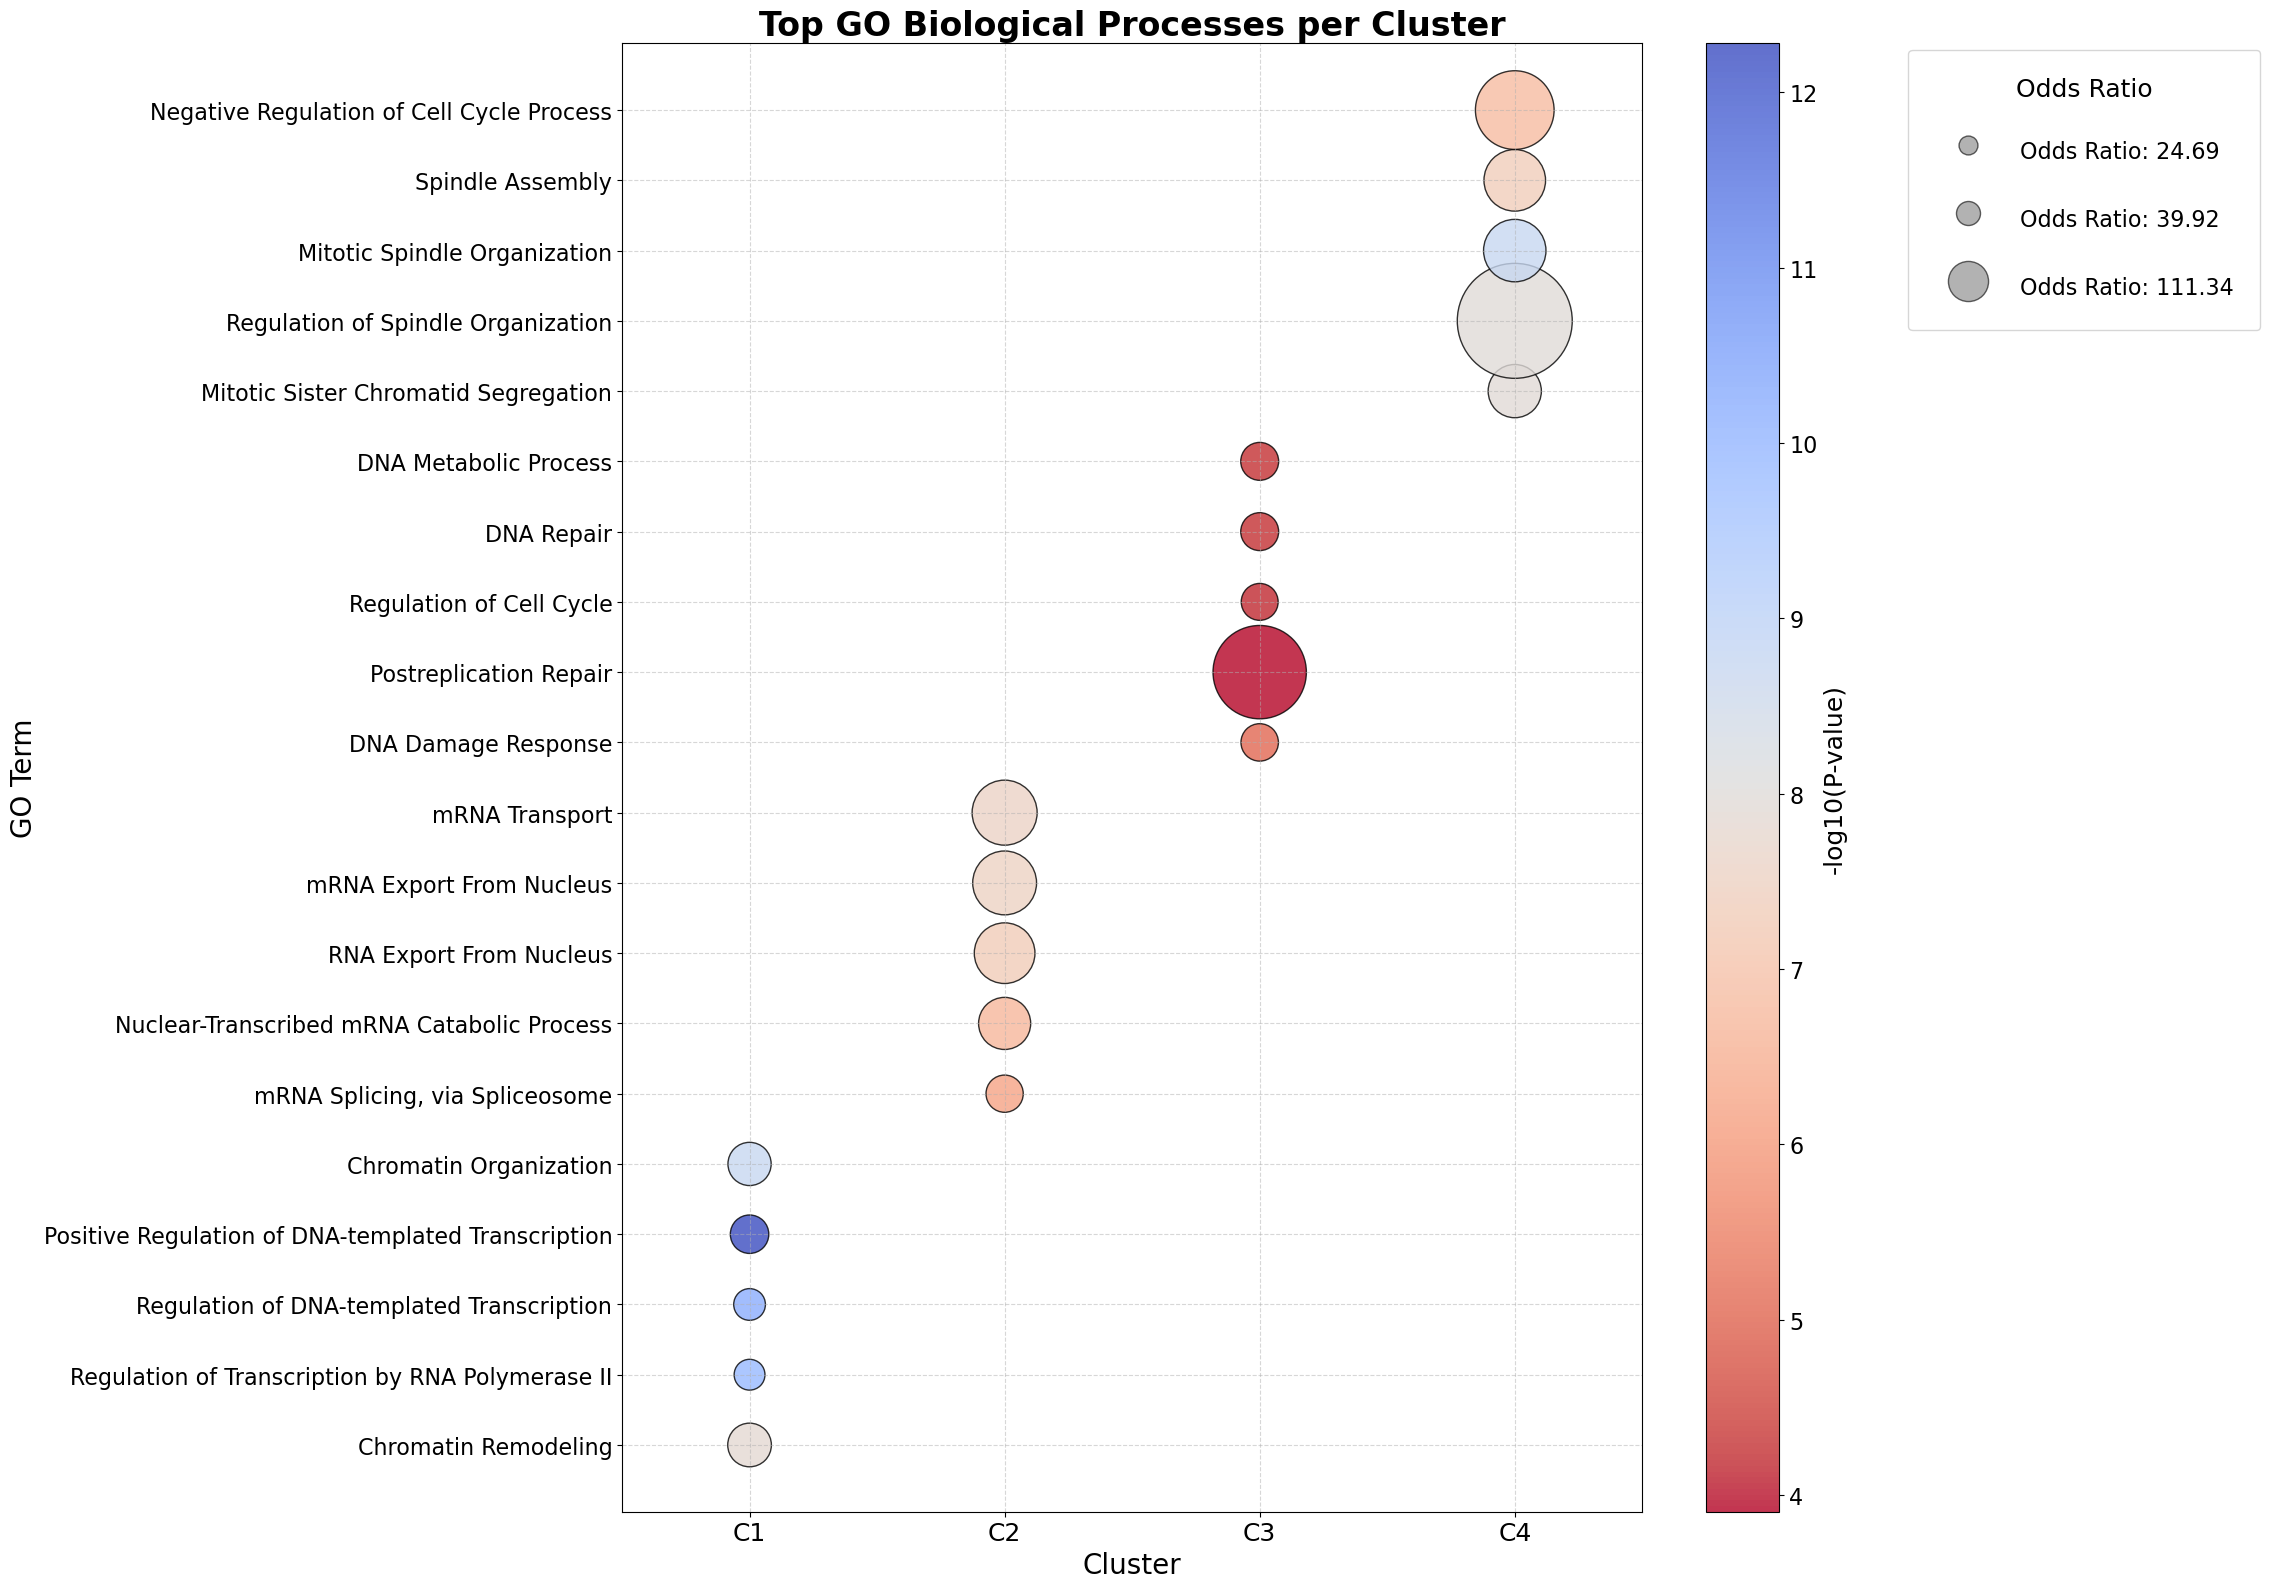

In [32]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# Set your data folder path
folder_path = "/Users/sanatm/Downloads/Network_Clusters"

# Get all relevant cluster files
file_list = [f for f in os.listdir(folder_path) if f.endswith("_table.txt") and "Cluster" in f]

# Initialize dataframe list
df_list = []

# Load each file
for file in file_list:
    cluster_match = re.search(r"Cluster(\d+)", file)
    if not cluster_match:
        continue
    cluster_id = f"C{cluster_match.group(1)}"

    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, sep="\t", usecols=["Term", "P-value", "Odds Ratio"])
    
    # Keep top 5 by P-value
    df = df.nsmallest(5, "P-value").copy()
    df["Cluster"] = cluster_id
    
    df_list.append(df)

# Combine all into one dataframe
all_data = pd.concat(df_list, ignore_index=True)

# Optional: clean up GO term names
all_data["Term"] = all_data["Term"].str.replace(r"\s*\(.*?\)", "", regex=True)
all_data = all_data.sort_values(by='Cluster').reset_index(drop=True)

# Add -log10(pvalue) for color
all_data["-log10(P-value)"] = -np.log10(all_data["P-value"])

# Order x-axis
cluster_order = ["C1", "C2", "C3", "C4"]
all_data["Cluster"] = pd.Categorical(all_data["Cluster"], categories=cluster_order, ordered=True)

# Begin plotting
# Begin plotting
fig, ax = plt.subplots(figsize=(12, 16))  # Slightly larger figure

# Plot
cluster_map = {c: i for i, c in enumerate(cluster_order)}
x_vals = all_data["Cluster"].map(cluster_map)

scatter = ax.scatter(
    x=x_vals,
    y=all_data["Term"],
    s=all_data["Odds Ratio"] * 30,
    c=all_data["-log10(P-value)"],
    cmap="coolwarm_r",
    alpha=0.8,
    edgecolors="black"
)

# Axes ticks
ax.set_xticks(range(len(cluster_order)))
ax.set_xticklabels(cluster_order, fontsize=18)  # X-tick font size
ax.set_yticklabels(all_data["Term"], fontsize=16)  # Y-tick font size

# Axis labels and grid
ax.set_xlabel("Cluster", fontsize=20)
ax.set_ylabel("GO Term", fontsize=20)
ax.set_title("Top GO Biological Processes per Cluster", fontsize=24, weight='bold')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlim(-0.5, len(cluster_order)-0.5)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("-log10(P-value)", fontsize=18)
cbar.ax.tick_params(labelsize=16)

# Odds Ratio legend
or_vals = np.quantile(all_data["Odds Ratio"], [0.25, 0.5, 0.9])
for val in or_vals:
    ax.scatter([], [], s=val * 30, c='gray', alpha=0.6, edgecolors='black', label=f'Odds Ratio: {val:.2f}')

legend = ax.legend(
    loc='center left',
    bbox_to_anchor=(1.25, 0.9),
    frameon=True,
    title="Odds Ratio",
    title_fontsize=18,
    fontsize=16,
    markerscale=0.5,
    borderpad=1.2,
    labelspacing=1.5,
    handlelength=3,
    handleheight=2
)

# Layout and save
plt.tight_layout(rect=[0, 0, 1.9, 1])
fig.savefig("/Users/sanatm/Downloads/Network_Clusters/Cluster_GO_Term_Enrichment.png", dpi=300, bbox_inches='tight')
plt.show()
